In [1]:
#Naive Risk Budgeting strategies between the PSP and GHP
#need to check again all the code------- IMPORTANT

In [2]:
import numpy as np
import pandas as pd
%matplotlib inline


In [3]:
def bt_mix(r1, r2, allocator, **kwargs):
    """Runs a back test (simulations) of allocating between a two sets of returns r1 and r2 are T * N Data Frames or returns
     where T is the time step index and N is the number of scenarios. allocator is a function that takes two sets of returns 
     and allocator specific parameters, and produces an allocation to the first portfolio (the rest of the money is invested in the GHP)
     as a T * 1 DataFrame
     Returns a T * N DataFrame of the resulting N portfolio scenarios
     """
    
    if not r1.shape == r2.shape:
        raise ValueError("r1 and r2 need to be the same number")
    weights = allocator(r1, r2, **kwargs)
    if not weights.shape == r1.shape:
        raise ValueError("Allocator returned weights that dont match r1")
    r_mix = weights*r1 + (1-weights)*r2
    return r_mix

In [4]:
def fixedmix_allocator(r1, r2, w1, *kwargs):
    """
    Produces a time series over T steps of allocations between
    the PSP and GHP are T * N DataFrames that represent the returns of the PSP and GHP such that:
    each column is a scenario
    each row is the price for a timestep
    Returns an T * N DataFrame of PSP Weights
    """
    return pd.DataFrame(data=w1, index=r1.index, columns=r1.columns)


In [5]:
def inst_to_ann(r):
    #converst short rate to annualized rate(r(annual)=e**r(inst)-1)
    return np.expm1(r)

def ann_to_inst(r):
    #converts annualized to short rate(r(inst)=log(1+r(annual))
    return np.log1p(r)

import math
def cir(n_years =10, n_scenarios=1, a=0.05, b=0.03, sigma=0.05, steps_per_year=12,r_0=None):
    if r_0 is None: r_0 = b
    r_0 = ann_to_inst(r_0)
    dt = 1/steps_per_year
    num_steps= int(n_years*steps_per_year) + 1 #because n_years might be a float
    
    shock = np.random.normal(0, scale=np.sqrt(dt), size=(num_steps, n_scenarios))
    rates =np.empty_like(shock)
    rates[0] = r_0
    
    #For Price generation 
    h = math.sqrt(a**2 + 2*sigma**2)
    prices = np.empty_like(shock)
    ###
    
    def price(ttm, r):
        _A = ((2*h*math.exp((h+a)*ttm/2))/(2*h+(h+a)*(math.exp(h*ttm)-1)))**(2*a*b/sigma**2)
        _B = (2*(math.exp(h*ttm)-1))/(2*h + (h+a)*(math.exp(h*ttm)-1))
        _P = _A*np.exp(-_B*r)
        return _P
    prices[0] = price(n_years, r_0)
    ####
    
    for step in range(1, num_steps):
        r_t = rates[step-1]
        d_r_t = a*(b-r_t)*dt + sigma*np.sqrt(r_t)*shock[step]
        rates[step] = abs(r_t + d_r_t)
        #generate prices at time as well....
        prices[step] = price(n_years-step*dt, rates[step])
        
    rates = pd.DataFrame(data=inst_to_ann(rates), index= range(num_steps))
    
    ### for prices
    prices = pd.DataFrame(data=prices, index=range(num_steps))
        
    return rates, prices

In [6]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from numpy.linalg import inv

from scipy.stats import skew
from scipy.stats import kurtosis

def drawdown(return_series: pd.Series):
    
    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index-previous_peaks)/previous_peaks
    return pd.DataFrame({
        "Wealth": wealth_index,
        "Peaks":  previous_peaks,
        "Drawdown": drawdowns
    })


def annualize_rets(s, periods_per_year):
    '''
    Computes the return per year, or, annualized return.
    The variable periods_per_year can be, e.g., 12, 52, 252, in 
    case of monthly, weekly, and daily data.
    The method takes in input either a DataFrame or a Series and, in the former 
    case, it computes the annualized return for every column (Series) by using pd.aggregate
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate( annualize_rets, periods_per_year=periods_per_year )
    elif isinstance(s, pd.Series):
        growth = (1 + s).prod()
        n_period_growth = s.shape[0]
        return growth**(periods_per_year/n_period_growth) - 1
    


def annualize_vol(s, periods_per_year):
    '''
    Computes the volatility per year, or, annualized volatility.
    The variable periods_per_year can be, e.g., 12, 52, 252, in 
    case of monthly, weekly, and daily data.
    The method takes in input either a DataFrame, a Series, a list or a single number. 
    In the former case, it computes the annualized volatility of every column 
    (Series) by using pd.aggregate. In the latter case, s is a volatility 
    computed beforehand, hence only annulization is done
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate(annualize_vol, periods_per_year=periods_per_year )
    elif isinstance(s, pd.Series):
        return s.std() * (periods_per_year)**(0.5)
    elif isinstance(s, list):
        return np.std(s) * (periods_per_year)**(0.5)
    elif isinstance(s, (int,float)):
        return s * (periods_per_year)**(0.5)

    
def sharpe_ratio(s, risk_free_rate, periods_per_year, v=None):
    '''
    Computes the annualized sharpe ratio. 
    The variable periods_per_year can be, e.g., 12, 52, 252, in case of yearly, weekly, and daily data.
    The variable risk_free_rate is the annual one.
    The method takes in input either a DataFrame, a Series or a single number. 
    In the former case, it computes the annualized sharpe ratio of every column (Series) by using pd.aggregate. 
    In the latter case, s is the (allready annualized) return and v is the (already annualized) volatility 
    computed beforehand, for example, in case of a portfolio.
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate( sharpe_ratio, risk_free_rate=risk_free_rate, periods_per_year=periods_per_year, v=None)
    elif isinstance(s, pd.Series):
        # convert the annual risk free rate to the period assuming that:
        # RFR_year = (1+RFR_period)^{periods_per_year} - 1. Hence:
        rf_to_period = (1 + risk_free_rate)**(1/periods_per_year) - 1        
        excess_return = s - rf_to_period
        # now, annualize the excess return
        ann_ex_rets = annualize_rets(excess_return, periods_per_year)
        # compute annualized volatility
        ann_vol = annualize_vol(s, periods_per_year)
        return ann_ex_rets / ann_vol
    elif isinstance(s, (int,float)) and v is not None:
        # Portfolio case: s is supposed to be the single (already annnualized) 
        # return of the portfolio and v to be the single (already annualized) volatility. 
        return (s - risk_free_rate) / v


    
    
def skewness(s):
    '''
    Computes the Skewness of the input Series or Dataframe.
    There is also the function scipy.stats.skew().
    '''
    return ( ((s - s.mean()) / s.std(ddof=0))**3 ).mean()

def kurtosis(s):
    '''
    Computes the Kurtosis of the input Series or Dataframe.
    There is also the function scipy.stats.kurtosis() which, however, 
    computes the "Excess Kurtosis", i.e., Kurtosis minus 3
    '''
    return ( ((s - s.mean()) / s.std(ddof=0))**4 ).mean()


def var_gaussian(s, level=0.05, cf=False):
    '''
    Returns the (1-level)% VaR using the parametric Gaussian method. 
    By default it computes the 95% VaR, i.e., alpha=0.95 which gives level 1-alpha=0.05.
    The variable "cf" stands for Cornish-Fisher. If True, the method computes the 
    modified VaR using the Cornish-Fisher expansion of quantiles.
    The method takes in input either a DataFrame or a Series and, in the former 
    case, it computes the VaR for every column (Series).
    '''
    # alpha-quantile of Gaussian distribution 
    za = scipy.stats.norm.ppf(level,0,1) 
    if cf:
        S = skewness(s)
        K = kurtosis(s)
        za = za + (za**2 - 1)*S/6 + (za**3 - 3*za)*(K-3)/24 - (2*za**3 - 5*za)*(S**2)/36    
    return -( s.mean() + za * s.std(ddof=0) )


def var_historic(s, level=0.05):
    '''
    Returns the (1-level)% VaR using historical method. 
    By default it computes the 95% VaR, i.e., alpha=0.95 which gives level 1-alpha=0.05.
    The method takes in input either a DataFrame or a Series and, in the former 
    case, it computes the VaR for every column (Series) by using pd.aggregate
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate( var_historic, level=level )
    elif isinstance(s, pd.Series):
        return - np.percentile(s, level*100)
    else:
        raise TypeError("Expected pd.DataFrame or pd.Series")

def cvar_historic(s, level=0.05):
    '''
    Computes the (1-level)% Conditional VaR (based on historical method).
    By default it computes the 95% CVaR, i.e., alpha=0.95 which gives level 1-alpha=0.05.
    The method takes in input either a DataFrame or a Series and, in the former 
    case, it computes the VaR for every column (Series).
    '''
    if isinstance(s, pd.DataFrame):
        return s.aggregate( cvar_historic, level=level )
    elif isinstance(s, pd.Series):
        # find the returns which are less than (the historic) VaR
        mask = s < -var_historic(s, level=level)
        # and of them, take the mean 
        return -s[mask].mean()
    else:
        raise TypeError("Expected pd.DataFrame or pd.Series")

def summary_stats(r, risk_free_rate=0.03):
    
    ann_r= r.aggregate(annualize_rets,periods_per_year=12)
    ann_vol = r.aggregate(annualize_vol,periods_per_year=12)
    ann_sr = r.aggregate(sharpe_ratio, risk_free_rate = risk_free_rate,periods_per_year=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian,cf=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis":kurt,
        "Corner-Fisher VaR (5%)": cf_var5,
        "Historic Cvar (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

In [8]:
def discount(t,r):
    #compute price of a pure discount bond that pays a dollar at time t,given interest rate r----CONTINUATION
    discounts = pd.DataFrame([(r+1)**-i for i in t])
    discounts.index = t
    return discounts

def pv(flows,r):
    #computes the present value of a sequnce of liabilities, l is indexed by the time,and the values are the amounts of each liability
    #returns the present value of sequence
    dates = flows.index
    discounts = discount(dates,r)
    return discounts.multiply(flows,axis='rows').sum()

In [9]:
def bond_cash_flows(maturity, principle=100, coupon_rate=0.03, coupons_per_year=12):
    #Returns a series of cash flows generated by a bond, indexed by a coupon number
    
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principle*coupon_rate/coupons_per_year
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data=coupon_amt, index = coupon_times)
    cash_flows.iloc[-1] += principle
    return cash_flows

def bond_price(maturity, principle =100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    #Price a bond based on bond parameters maturity, principle, coupon rate and coupons_per_year and 
    #prevailing discount rate
    
    if isinstance(discount_rate, pd.DataFrame):
        pricing_dates = discount_rate.index
        prices = pd.DataFrame(index=pricing_dates, columns=discount_rate.columns)
        for t in pricing_dates:
            prices.loc[t] = bond_price(maturity-t/coupons_per_year, principle, coupon_rate, coupons_per_year,
                                      discount_rate.loc[t])
        return prices
    else:#base case.... single time period
        if maturity <= 0: return principle+principle*coupon_rate/coupons_per_year
        cash_flows = bond_cash_flows(maturity, principle, coupon_rate, coupons_per_year)
        return pv(cash_flows, discount_rate/coupons_per_year)

In [10]:
def bond_total_return(monthly_prices, principle, coupon_rate, coupons_per_year):
    
    coupons = pd.DataFrame(data=0, index=monthly_prices.index, columns=monthly_prices.columns)
    t_max = monthly_prices.index.max()
    pay_date = np.linspace(12/coupons_per_year, t_max, int(coupons_per_year*t_max/12), dtype=int)
    coupons.iloc[pay_date]= principle*coupon_rate/coupons_per_year
    total_returns = (monthly_prices + coupons)/monthly_prices.shift()-1
    return total_returns.dropna()

In [12]:
rates, zc_prices = cir(10, 500, b=0.03, r_0=0.03)
price_10 = bond_price(10, 100, 0.05, 12, rates)
price_30 = bond_price(30, 100, 0.05, 12, rates)
rets_30 = bond_total_return(price_30, 100, 0.05, 12)
rets_10 = bond_total_return(price_10, 100, 0.05, 12)
rets_bonds = bt_mix(rets_10, rets_30, allocator=fixedmix_allocator, w1=0.6)
mean_rets_bonds = rets_bonds.mean(axis='columns')
summary_stats(pd.DataFrame(mean_rets_bonds))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Corner-Fisher VaR (5%),Historic Cvar (5%),Sharpe Ratio,Max Drawdown
0,0.035968,0.003739,0.092672,3.304412,-0.001217,-0.000697,1.553438,-0.000173


In [13]:
def gbm(n_years = 10, n_scenarios=1000, mu=0.07, sigma=0.15, steps_per_year=12, start=100.0, prices=True):
    """
    Evolution of Geometric Brownian Motion trajectories, such as for Stock Prices through Monte Carlo
    :param n_years:  The number of years to generate data for
    :param n_paths: The number of scenarios/trajectories
    :param mu: Annualized Drift, e.g. Market Return
    :param sigma: Annualized Volatility
    :param steps_per_year: granularity of the simulation
    :param s_0: initial value
    :return: a numpy array of n_paths columns and n_years*steps_per_year rows
    """
    # Derive per-step Model Parameters from User Specifications
    dt = 1/steps_per_year
    n_steps = int(n_years*steps_per_year) + 1
    # the standard way ...
    # rets_plus_1 = np.random.normal(loc=mu*dt+1, scale=sigma*np.sqrt(dt), size=(n_steps, n_scenarios))
    # without discretization error ...
    rets_plus_1 = np.random.normal(loc=(1+mu)**dt, scale=(sigma*np.sqrt(dt)), size=(n_steps, n_scenarios))
    rets_plus_1[0] = 1
    ret_val = start*pd.DataFrame(rets_plus_1).cumprod() if prices else rets_plus_1-1
    return ret_val

In [15]:
price_eq = gbm(n_years=10, n_scenarios=500, mu=0.07, sigma=0.15)
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()

In [17]:
rets_7030b = bt_mix(rets_eq, rets_bonds, allocator=fixedmix_allocator, w1=0.7)
rets_7030b_mean = rets_7030b.mean(axis=1)
summary_stats(pd.DataFrame(rets_7030b_mean))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Corner-Fisher VaR (5%),Historic Cvar (5%),Sharpe Ratio,Max Drawdown
0,0.060396,0.004226,-0.295959,2.82672,-0.002797,-0.002218,7.001008,0.0


In [18]:
summaries = summary_stats(rets_7030b)
summaries.head()

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Corner-Fisher VaR (5%),Historic Cvar (5%),Sharpe Ratio,Max Drawdown
0,0.068311,0.107583,-0.179538,2.757071,0.046582,0.057158,0.346468,-0.232154
1,0.076338,0.117347,-0.014098,2.717354,0.049099,0.060591,0.384194,-0.244576
2,0.090223,0.101923,-0.074099,2.586294,0.041401,0.050948,0.574979,-0.120575
3,-0.052573,0.103567,0.223171,2.997186,0.051103,0.062514,-0.776028,-0.485535
4,0.056144,0.093960,0.292802,2.766749,0.037340,0.042450,0.270702,-0.136883


In [19]:
summaries.mean()

Annualized Return         0.054910
Annualized Vol            0.107595
Skewness                 -0.001279
Kurtosis                  2.935383
Corner-Fisher VaR (5%)    0.046000
Historic Cvar (5%)        0.058176
Sharpe Ratio              0.226803
Max Drawdown             -0.208187
dtype: float64

In [20]:
def terminal_values(rets):
    """Return the final value of a dollar at the end of the reurn period for each scenario"""
    return (rets+1).prod()


In [35]:
def terminal_stats(rets, floor= 0.08, cap=np.inf, name ="Stats"):


#Produce summary statistics on the terminal values per invested dollar
#across a range of N scenarios
#rets is T * N DataFrame of returns, where T is the time-step(we assume rets is sorted by time,
#Returns a 1 column DataFrame of Summary Stats indexed by the stat name


    terminal_wealth = (rets+1).prod()
    breach = terminal_wealth < floor
    reach = terminal_wealth >= cap
    p_breach = breach.mean() if breach.sum() > 0 else np.nan
    p_reach = breach.mean() if reach.sum() > 0 else np.nan
    e_short = (floor-terminal_wealth[breach]).mean() if breach.sum() > 0 else np.nan
    e_surplus = (cap-terminal_wealth[reach]).mean() if reach.sum() > 0 else np.nan
    sum_stats = pd.DataFrame.from_dict({
        "mean": terminal_wealth.mean(),
        "std":  terminal_wealth.std(),
        "p_breach": p_breach,
        "e_short": e_short,
        "p_reach": p_reach,
        "e_surplus": e_surplus
    }, orient = "index", columns=[name])
    return sum_stats

In [36]:
pd.concat([
     terminal_stats(rets_bonds, name="FI"),
     terminal_stats(rets_eq, name = "EQ"),
     terminal_stats(rets_7030b, name="70/30")
    
    
], axis=1)

,FI,EQ,70/30
mean,1.384648,2.001015,1.798401
std,0.111480,1.081974,0.649919
p_breach,NaN,NaN,NaN
e_short,NaN,NaN,NaN
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


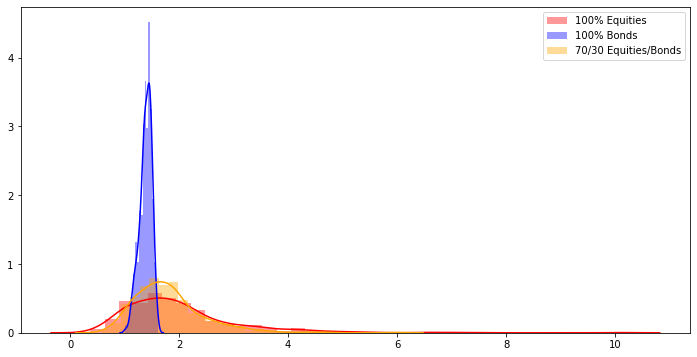

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
sns.distplot(terminal_values(rets_eq), color="red", label="100% Equities")
sns.distplot(terminal_values(rets_bonds), color="blue", label="100% Bonds")
sns.distplot(terminal_values(rets_7030b), color="orange", label="70/30 Equities/Bonds")
plt.legend();

In [38]:
#Glide path allocator

In [39]:
def glidepath_allocator(r1, r2, start_glide=1, end_glide=0):
    #simulate a target-data-fund style gradual move from r1 to r2
    
    n_points = r1.shape[0]
    n_col = r1.shape[1]
    path = pd.Series(data=np.linspace(start_glide, end_glide, num=n_points))
    paths = pd.concat([path]*n_col, axis=1)
    paths.index = r1.index
    paths.columns = r1.columns
    return paths

In [40]:
rets_g8020 = bt_mix(rets_eq, rets_bonds, allocator=glidepath_allocator, start_glide=0.80, end_glide=0.20)
pd.concat([
     terminal_stats(rets_bonds, name="FI"),
     terminal_stats(rets_eq, name = "EQ"),
     terminal_stats(rets_7030b, name="70/30"),
     terminal_stats(rets_g8020, name="Glide 80 to 20")
    
    
    
], axis=1)

,FI,EQ,70/30,Glide 80 to 20
mean,1.384648,2.001015,1.798401,1.665396
std,0.111480,1.081974,0.649919,0.445408
p_breach,NaN,NaN,NaN,NaN
e_short,NaN,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [41]:
#Dyamic risk budgeting

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [43]:
n_scenarios = 5000
rates, zc_prices = cir(10,n_scenarios=n_scenarios, b=0.03, r_0=0.03,sigma=0.02)
price_eq = gbm(n_years=10, n_scenarios=n_scenarios, mu=0.07, sigma=0.15)


In [44]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = bt_mix(rets_eq, rets_zc, allocator=fixedmix_allocator, w1=0.7)
pd.concat([
     terminal_stats(rets_zc, name="zc", floor=0.75),
     terminal_stats(rets_eq, name = "EQ", floor=0.75),
     terminal_stats(rets_7030b, name="70/30", floor=0.75),],
    axis=1).round(2)


,zc,EQ,70/30
mean,1.34,1.97,1.76
std,0.00,0.99,0.60
p_breach,NaN,0.03,0.01
e_short,NaN,0.12,0.08
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [45]:
def floor_allocator(psp_r,ghp_r, floor, zc_prices, m=3):
    """Allocate between PSP nad GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI- style dynamic risk budegting algorithm by investing a multiple of the cushion
    in the PSP 
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    if zc_prices.shape != psp_r.shape:
        raise ValueError("PSP and ZC prices must have the same shape")
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = floor*zc_prices.iloc[step] ##PV of Floor assuming todays rates and flat YC
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0,1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        w_history.iloc[step]= psp_w
    return w_history

In [46]:
rets_floor75 = bt_mix(rets_eq, rets_zc, allocator=floor_allocator,floor=0.75, zc_prices=zc_prices[1:])
pd.concat([
     terminal_stats(rets_zc, name="zc", floor=0.75),
     terminal_stats(rets_eq, name = "EQ", floor=0.75),
     terminal_stats(rets_7030b, name="70/30", floor=0.75),
    terminal_stats(rets_floor75, name="floor75", floor=0.75),
    ],
    axis=1).round(2)



,zc,EQ,70/30,floor75
mean,1.34,1.97,1.76,1.94
std,0.00,0.99,0.60,1.00
p_breach,NaN,0.03,0.01,NaN
e_short,NaN,0.12,0.08,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [48]:
rets_floor75m1 = bt_mix(rets_eq, rets_zc, allocator=floor_allocator,floor=0.75, zc_prices=zc_prices[1:], m=1)
rets_floor75m5 = bt_mix(rets_eq, rets_zc, allocator=floor_allocator,floor=0.75, zc_prices=zc_prices[1:], m=5)
pd.concat([
     terminal_stats(rets_zc, name="zc", floor=0.75),
     terminal_stats(rets_eq, name = "EQ", floor=0.75),
     terminal_stats(rets_7030b, name="70/30", floor=0.75),
     terminal_stats(rets_floor75, name="floor75", floor=0.75),
     terminal_stats(rets_floor75m1, name="floor75m1", floor=0.75),
     terminal_stats(rets_floor75m5, name="floor75m5", floor=0.75),
    ],
    axis=1).round(4)

,zc,EQ,70/30,floor75,floor75m1,floor75m5
mean,1.3433,1.9679,1.7554,1.9448,1.6211,1.9553
std,0.0000,0.9919,0.6000,0.9968,0.4378,0.9993
p_breach,NaN,0.0348,0.0090,NaN,NaN,NaN
e_short,NaN,0.1241,0.0801,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Risk budgeting with draw down constraints


In [54]:
def drawdown_allocator(psp_r,ghp_r, maxdd, m=3):
    """Allocate between PSP nad GHP with the goal to provide exposure to the upside
    of the PSP without going violating the floor.
    Uses a CPPI- style dynamic risk budegting algorithm by investing a multiple of the cushion
    in the PSP 
    Returns a DataFrame with the same shape as the psp/ghp representing the weights in the PSP
    """
    
    n_steps, n_scenarios = psp_r.shape
    account_value = np.repeat(1, n_scenarios)
    floor_value = np.repeat(1, n_scenarios)
    peak_value = np.repeat(1, n_scenarios)
    w_history = pd.DataFrame(index=psp_r.index, columns=psp_r.columns)
    for step in range(n_steps):
        floor_value = (1-maxdd)*peak_value ##Floor is based on previous peak
        cushion = (account_value - floor_value)/account_value
        psp_w = (m*cushion).clip(0,1) # same as applying min and max
        ghp_w = 1-psp_w
        psp_alloc = account_value*psp_w
        ghp_alloc = account_value*ghp_w
        # recompute the new account value at the end of this step
        account_value = psp_alloc*(1+psp_r.iloc[step]) + ghp_alloc*(1+ghp_r.iloc[step])
        peak_value = np.maximum(peak_value, account_value)
        w_history.iloc[step]= psp_w
    return w_history

In [55]:
cashrate= 0.02
monthly_cashreturn = (1+cashrate)**(1/12) -1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = bt_mix(rets_eq, rets_cash, allocator=drawdown_allocator, maxdd=.25)
tv_maxdd25 = terminal_values(rets_maxdd25)
pd.concat([
     terminal_stats(rets_zc, name="zc", floor=0.75),
     terminal_stats(rets_eq, name = "EQ", floor=0.75),
     terminal_stats(rets_7030b, name="70/30", floor=0.75),
     terminal_stats(rets_floor75, name="floor75", floor=0.75),
     terminal_stats(rets_floor75m1, name="floor75m1", floor=0.75),
     terminal_stats(rets_floor75m5, name="floor75m5", floor=0.75),
     terminal_stats(rets_maxdd25, name="MaxDD25", floor=0.75),
    ],
    axis=1).round(4)

,zc,EQ,70/30,floor75,floor75m1,floor75m5,MaxDD25
mean,1.3433,1.9679,1.7554,1.9448,1.6211,1.9553,1.6264
std,0.0000,0.9919,0.6000,0.9968,0.4378,0.9993,0.5473
p_breach,NaN,0.0348,0.0090,NaN,NaN,NaN,NaN
e_short,NaN,0.1241,0.0801,NaN,NaN,NaN,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
summary_stats(rets_maxdd25)["Max Drawdown"].head()


0   -0.172406
1   -0.178689
2   -0.216476
3   -0.131052
4   -0.208256
Name: Max Drawdown, dtype: float64

In [58]:
summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.23683697370028428

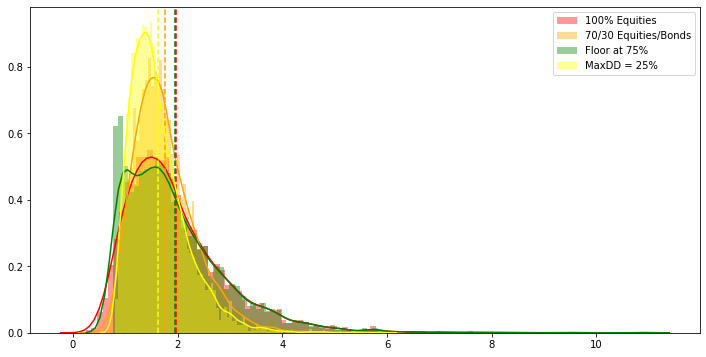

In [59]:
tv_eq = terminal_values(rets_eq)
tv_zc = terminal_values(rets_zc)
tv_7030b = terminal_values(rets_7030b)
tv_floor75 = terminal_values(rets_floor75)
tv_maxdd25 = terminal_values(rets_maxdd25)
#plot
plt.figure(figsize=(12,6))
sns.distplot(tv_eq, color="red", label="100% Equities", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")
sns.distplot(tv_7030b, color="orange", label="70/30 Equities/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")
sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")
sns.distplot(tv_maxdd25, color="yellow", label="MaxDD = 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls='--', color="yellow")
plt.legend();

